In [2]:
# Load packages

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import cmasher as cmr
import random
from unyt import Msun, yr, Mpc, angstrom
import seaborn as sns
import pandas as pd
import os
from matplotlib.gridspec import GridSpec

from synthesizer.grid import Grid
from synthesizer.load_data.load_scsam import load_SCSAM
from synthesizer.emission_models import (
    BlackHoleEmissionModel,
    GalaxyEmissionModel,
    StellarEmissionModel,
    AttenuatedEmission,
    TotalEmission
)
from synthesizer.particle.galaxy import Galaxy as ParticleGalaxy
from synthesizer.particle.stars import Stars as ParticleStars
from synthesizer.particle import BlackHoles, Gas
from synthesizer.emission_models.attenuation import ParametricLi08

plt.rcParams['figure.dpi'] = 100
mpl.rcParams.update({'font.size': 14})

In [44]:
# First let's get all of the local SAM galaxies to compare our most extreme galaxy to

sam_dir = '/mnt/ceph/users/lperez/AGNmodelingSCSAM/sam_newAGNcode_allzs_Sophie/h5files'
sv = "0_0_0"

with h5py.File(f'{sam_dir}/volume.hdf5', 'r') as f:
    group = f[f"{sv}/Galprop"]

    # Load redshift first to make the mask
    redshift = group['GalpropRedshift'][:]
    redshift_mask = (redshift >= 0) & (redshift < 0.1)

    # Load only the subset you need using the mask
    stellar_mass = group['GalpropMstar'][:][redshift_mask] * 1e9 # Msolar
    metal_mass = group['GalpropZstar'][:][redshift_mask] * 1e9 # Msolar Zsolar
    disk_radius = group['GalpropRdisk'][:][redshift_mask] # kpc
    gas_mass = group['GalpropMcold'][:][redshift_mask] * 1e9 # Msolar
    redshift = redshift[redshift_mask]
    stellar_mass_merge = group['GalpropMstar_merge'][:][redshift_mask] * 1e9 # Msolar
    maccdot = group['GalpropMaccdot_bright'][:][redshift_mask]
    halo_mass = group['GalpropMhalo'][:][redshift_mask] * 1e9 # Msolar
    outflow_rate_mass = group['GalpropOutflowRate_Mass'][:][redshift_mask] # Msolar/yr
    outflow_rate_metal = group['GalpropOutflowRate_Metal'][:][redshift_mask] # Msolar/yr
    fric_radius = group['GalpropRfric'][:][redshift_mask] # kpc
    sfr = group['GalpropSFR'][:][redshift_mask] # Msolar/yr
    t_merger = group['GalpropTmerger'][:][redshift_mask] # Gyr
    t_merger_major = group['GalpropTmerger_major'][:][redshift_mask] # Gyr

# Compute derived properties
Z_gas = metal_mass / gas_mass # Zsolar

print('N galaxies:', len(Z_gas))

# Calculate Av for all galaxies with a fixed inclination
cosine_incs = 1
k_v = 3.4822e4  # cm^2/g
log_Av_values = np.log(4.4e-3) - np.log(cosine_incs) + np.log(k_v) + np.log(metal_mass / 1e10) - 2*np.log(disk_radius)
Av_values = np.exp(log_Av_values)

N galaxies: 149033


/tmp/ipykernel_365038/519608529.py:30: RuntimeWarning: divide by zero encountered in divide
  Z_gas = metal_mass / gas_mass # Zsolar


In [10]:
# Get the index of the most extreme galaxy
index = np.argmax(Av_values)
print("Index of galaxy with largest Av:", index)
print('-----')
print("log(Av) =", np.log10(Av_values[index]))
print("Stellar mass =", stellar_mass[index], 'Msolar')
print("Disk radius =", disk_radius[index], 'kpc')
print("Gas mass =", gas_mass[index], 'Msolar')
print("Metal mass =", metal_mass[index], 'Msolar Zsolar')
print("Zgas =", Z_gas[index], 'Zsolar')
print("Redshift =", redshift[index])

Index of galaxy with largest Av: 134124
-----
log(Av) = 6.750701240034627
Stellar mass = 1.0162e+11 Msolar
Disk radius = 0.0215816 kpc
Gas mass = 3.39531e+08 Msolar
Metal mass = 1.71223e+11 Msolar Zsolar
Zgas = 504.2927 Zsolar
Redshift = 0.0723861


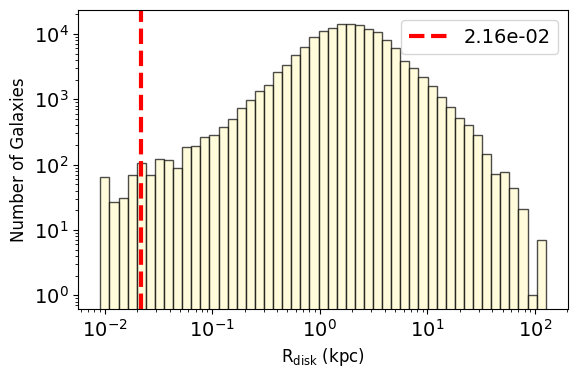

In [22]:
# Disk radius

extreme = disk_radius[index]

# log bins
n_bins = 50
log_min = np.log10(disk_radius.min())
log_max = np.log10(disk_radius.max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(disk_radius, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'$\rm R_{disk}$ (kpc)', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

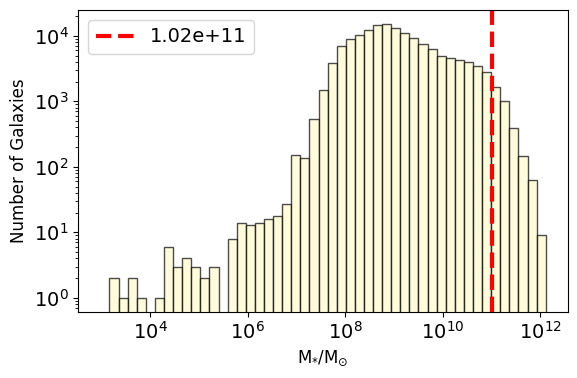

In [23]:
# Stellar mass

extreme = stellar_mass[index]

# log bins
n_bins = 50
log_min = np.log10(stellar_mass.min())
log_max = np.log10(stellar_mass.max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(stellar_mass, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'$\rm M_{*}/M_{\odot}$', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

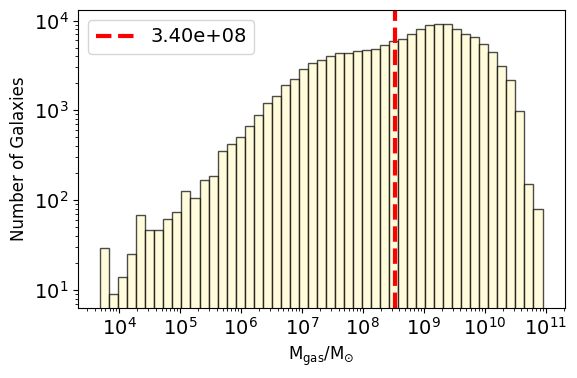

In [ ]:
extreme = gas_mass[index]

# log bins
mask = gas_mass > 0
n_bins = 50
log_min = np.log10(gas_mass[mask].min())
log_max = np.log10(gas_mass[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(gas_mass[mask], bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'$\rm M_{gas}/M_{\odot}$', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

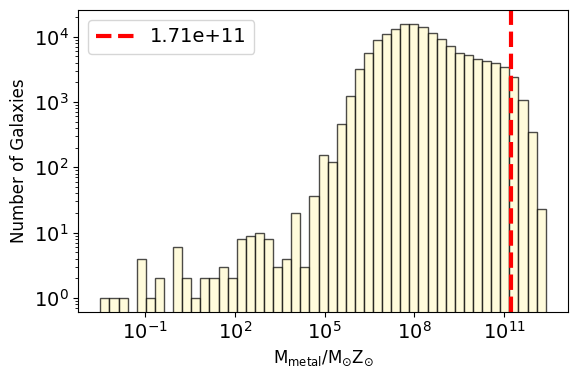

In [ ]:
extreme = metal_mass[index]

# log bins
n_bins = 50
log_min = np.log10(metal_mass.min())
log_max = np.log10(metal_mass.max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(metal_mass, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'$\rm M_{metal}/M_{\odot}Z_{\odot}$', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

5.3506062e-12 inf


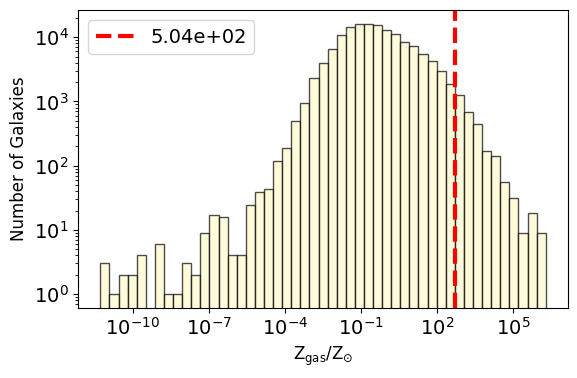

In [ ]:
extreme = Z_gas[index]

print(min(Z_gas), max(Z_gas))

# log bins
mask = (Z_gas > 0) & np.isfinite(Z_gas)
n_bins = 50
log_min = np.log10(Z_gas[mask].min())
log_max = np.log10(Z_gas[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(Z_gas[mask], bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'$\rm Z_{gas}/Z_{\odot}$', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

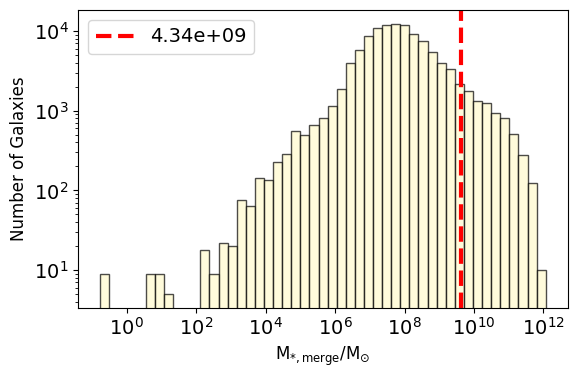

In [42]:
# Stellar mass entered through most recent mergers

extreme = stellar_mass_merge[index]

# log bins
mask = stellar_mass_merge > 0
n_bins = 50
log_min = np.log10(stellar_mass_merge[mask].min())
log_max = np.log10(stellar_mass_merge[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(stellar_mass_merge, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'$\rm M_{*,merge}/M_{\odot}$', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

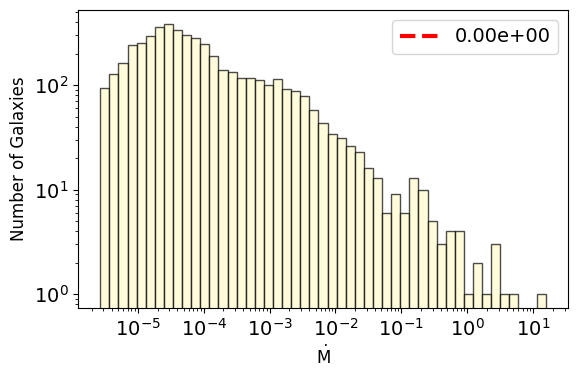

In [45]:
extreme = maccdot[index]

# log bins
mask = maccdot > 0
n_bins = 50
log_min = np.log10(maccdot[mask].min())
log_max = np.log10(maccdot[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(maccdot, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'$\rm \dot{M}$', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

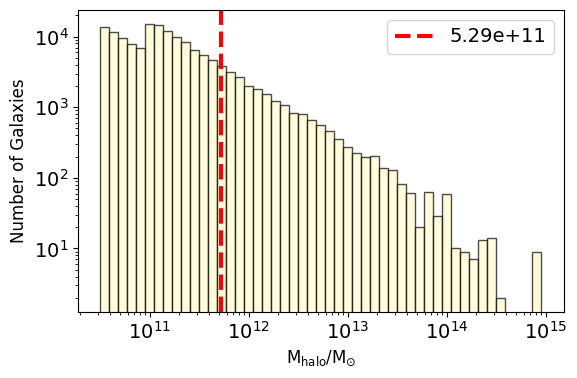

In [47]:
extreme = halo_mass[index]

# log bins
mask = halo_mass > 0
n_bins = 50
log_min = np.log10(halo_mass[mask].min())
log_max = np.log10(halo_mass[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(halo_mass, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'$\rm M_{halo}/M_{\odot}$', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

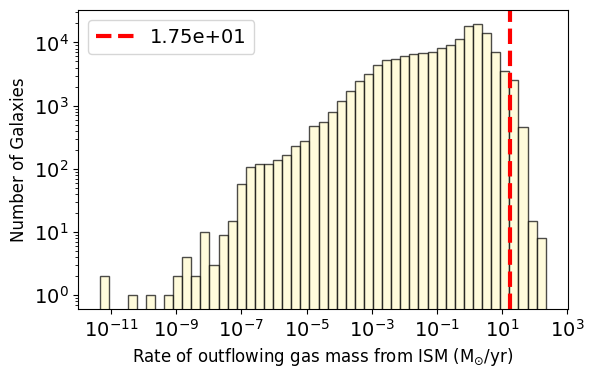

In [51]:
extreme = outflow_rate_mass[index]

# log bins
mask = outflow_rate_mass > 0
n_bins = 50
log_min = np.log10(outflow_rate_mass[mask].min())
log_max = np.log10(outflow_rate_mass[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(outflow_rate_mass, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'Rate of outflowing gas mass from ISM ($\rm M_{\odot}/yr$)', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

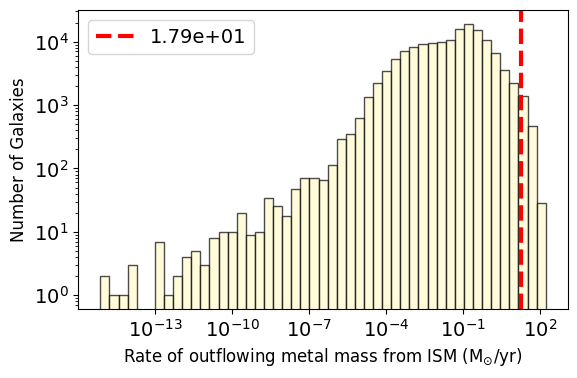

In [52]:
extreme = outflow_rate_metal[index]

# log bins
mask = outflow_rate_metal > 0
n_bins = 50
log_min = np.log10(outflow_rate_metal[mask].min())
log_max = np.log10(outflow_rate_metal[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(outflow_rate_metal, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'Rate of outflowing metal mass from ISM ($\rm M_{\odot}/yr$)', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

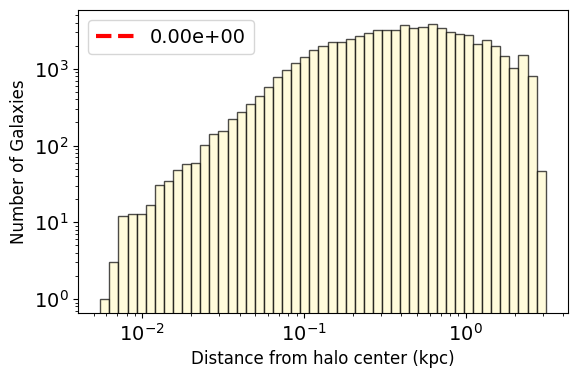

In [54]:
extreme = fric_radius[index]

# log bins
mask = fric_radius > 0
n_bins = 50
log_min = np.log10(fric_radius[mask].min())
log_max = np.log10(fric_radius[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(fric_radius, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'Distance from halo center (kpc)', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

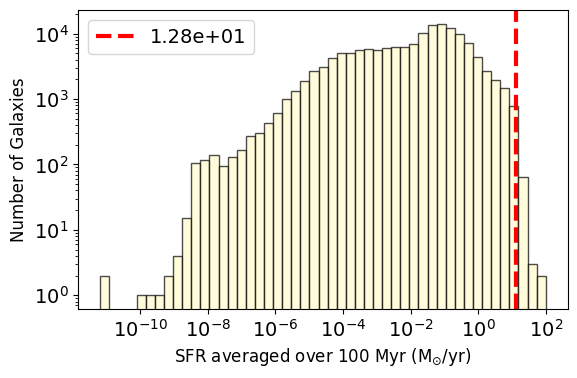

In [55]:
extreme = sfr[index]

# log bins
mask = sfr > 0
n_bins = 50
log_min = np.log10(sfr[mask].min())
log_max = np.log10(sfr[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(sfr, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'SFR averaged over 100 Myr ($\rm M_{\odot}/yr$)', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

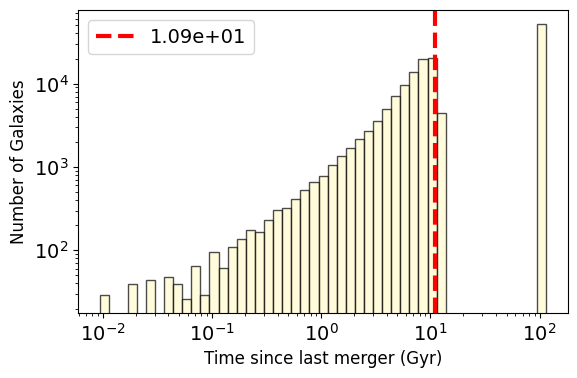

In [61]:
extreme = t_merger[index]

# log bins
mask = t_merger > 0
n_bins = 50
log_min = np.log10(t_merger[mask].min())
log_max = np.log10(t_merger[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(t_merger, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'Time since last merger (Gyr)', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

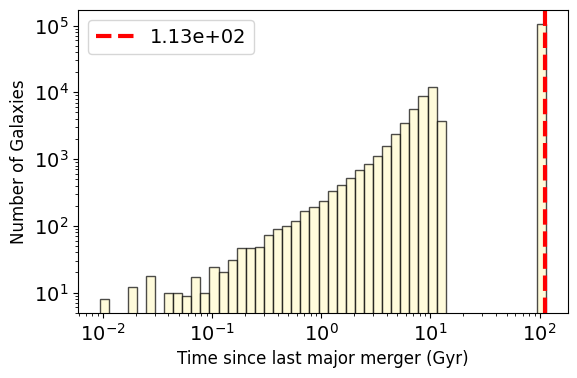

In [57]:
extreme = t_merger_major[index]

# log bins
mask = t_merger_major > 0
n_bins = 50
log_min = np.log10(t_merger_major[mask].min())
log_max = np.log10(t_merger_major[mask].max())
bins = np.logspace(log_min, log_max, n_bins)

# Make the histogram
plt.figure(figsize=(6, 4))
plt.hist(t_merger_major, bins=bins, alpha=0.7, color='lemonchiffon', edgecolor='black')
plt.axvline(extreme, color='red', linestyle='--', linewidth=3, label=f'{extreme:.2e}')

plt.xlabel(r'Time since last major merger (Gyr)', fontsize=12)
plt.ylabel('Number of Galaxies', fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()